#Global Imports (run before anything else)

In [ ]:
!pip install medmnist
from medmnist import OrganAMNIST
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from collections import Counter

#for CNN
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from sklearn import metrics
import torchvision
import time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=7e6fd625777521b887b8bbb1cdc06fd436f7e994704879753e8e3191f7ce3a1c
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


#Task 1


In [ ]:
#import the OrganAMNIST dataset from memnist, set downloads to true
#or else code won't work as its not installed.
train_dataset = OrganAMNIST(split="train", download=True)

#split into validation and test set for later on
val_dataset = OrganAMNIST(split="val", download=True)
test_dataset = OrganAMNIST(split="test", download=True)

100%|██████████| 38.2M/38.2M [00:01<00:00, 21.7MB/s]


Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz


In [ ]:
#data preprocessing (this was from the official medmist github repository,
#(we need to compute our own normalization factors)

transform = transforms.Compose([
    #conver the image to pytorch sensor to scale the pixel value to (0,1)
    transforms.ToTensor(),
    #from the repo, they normalized it with mean 0.5 and standard deviation 0.5
    #images range will be -1 to 1
    transforms.Normalize(mean=[.5], std=[.5]),
    #important! we need to flatten the image to 28*28 2D to 1D = 784
    transforms.Lambda(lambda x: x.view(-1))
])

# transform each of the train, val and test
train_dataset.transform = transform
val_dataset.transform = transform
test_dataset.transform = transform


# Use DataLoader like that from the repository, set batch size to 128.
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Shape of one batch of images: torch.Size([128, 784])
Shape of one batch of labels: torch.Size([128, 1])


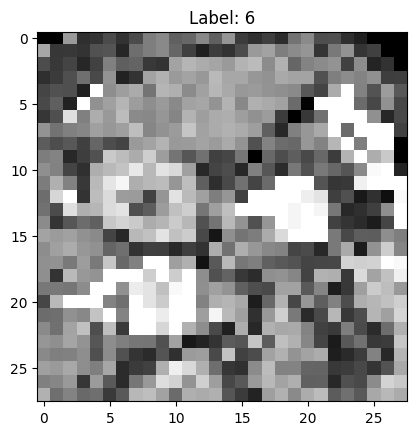

In [ ]:
# check the prepared Data
# check the first batch to verify everything is working correctly
data_iteration = iter(train_loader)
images, labels = next(data_iteration)

print("Shape of one batch of images:", images.shape)  # Should be (batch_size, 784)
print("Shape of one batch of labels:", labels.shape)  # Should be (batch_size, 128 (the batch size we set))

# Display the image in a 28x28 view
image = images[0].view(28, 28)  # Reshape the flattened image to 28x28 for visualization
plt.imshow(image, cmap='grey')
plt.title(f'Label: {labels[0].item()}')
plt.show()

#we see that since it is shuffled, each time we are getting a different organ from the dataset.

In [ ]:
print(train_dataset)
print("*" * 80)
print(test_dataset)

Dataset OrganAMNIST of size 28 (organamnist)
    Number of datapoints: 34561
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}
    Number of samples: {'train': 34561, 'val': 6491, 'test': 17778}
    Description: The OrganAMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Axial (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in axial views (planes). The images are resized into 1×28×28 to perform multi-cla

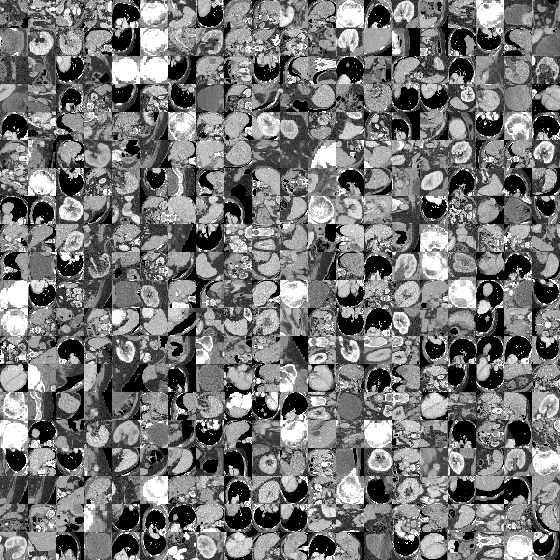

In [ ]:
#this gives us a really cool montage of different medical images of the organ dataset!!
#so cool
train_dataset.montage(length=20)

Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz


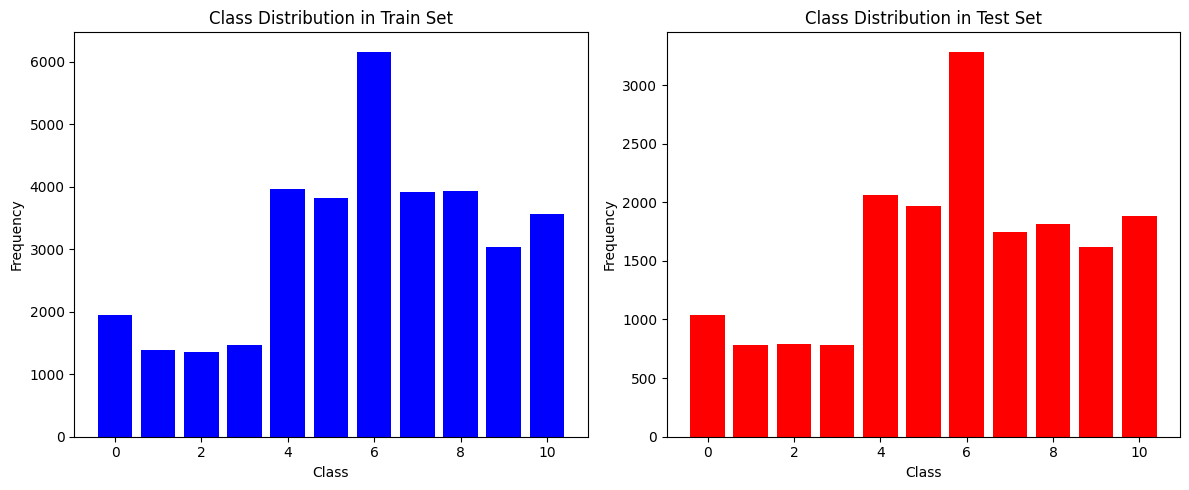

In [ ]:
data_transform_28 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

data_transform_128 = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


train_dataset_28 = OrganAMNIST(split="train", download=True, transform=data_transform_28)
test_dataset_28 = OrganAMNIST(split="test", download=True, transform=data_transform_28)

train_dataset_128 = OrganAMNIST(split="train", download=True, transform=data_transform_128)
test_dataset_128 = OrganAMNIST(split="test", download=True, transform=data_transform_128)

train_loader_28 = DataLoader(train_dataset_28, batch_size=32, shuffle=True)
test_loader_28 = DataLoader(test_dataset_28, batch_size=32, shuffle=False)

train_loader_128 = DataLoader(train_dataset_128, batch_size=32, shuffle=True)
test_loader_128 = DataLoader(test_dataset_128, batch_size=32, shuffle=False)


#EDA (Class distribution)
train_labels = [label.item() for _, label in train_dataset_28]
test_labels = [label.item() for _, label in test_dataset_28]

train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

# Plot Class Distribution for Train and Test Sets
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#x- axis is the classes, y is the frequency which represents the count of samples belonging to each class in the dataset

#the frequency tells us how many training or test images are labeled as each particular class

#PLOT FOR CLASS DISTRIBUTION IN TRAIN SET
axes[0].bar(train_label_counts.keys(), train_label_counts.values(), color='b')
axes[0].set_title('Class Distribution in Train Set')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Frequency')

#PLOT FOR THE CLASS DISTRIBUTION IN TEST SET
axes[1].bar(test_label_counts.keys(), test_label_counts.values(), color='r')
axes[1].set_title('Class Distribution in Test Set')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Prepare data for 3.1 to 3.3

# need:
# X_train: training data (images flattened to 1D)
# X_test: test data (images flattened to 1D)
# y_train_one_hot: one-hot encoded training labels
# y_test_one_hot: one-hot encoded test labels

# transform function to normalize and flatten the images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.Lambda(lambda x: x.view(-1))
])

# Load the train and test datasets. Default size = 28 x 28
train_dataset = OrganAMNIST(split="train", download=True, transform=transform)
test_dataset = OrganAMNIST(split="test", download=True, transform=transform)

# Convert datasets to NumPy arrays
def dataset_to_numpy(dataset):
    data = []
    labels = []

    for img, label in dataset:
        data.append(img.numpy())
        labels.append(label)

    data = np.array(data)
    labels = np.array(labels)

    return data, labels

# Convert train and test datasets to NumPy arrays
X_train, y_train = dataset_to_numpy(train_dataset)
X_test, y_test = dataset_to_numpy(test_dataset)

# one-hot encoding function for the labels
def one_hot_encode(labels, num_classes):
    one_hot_encoded = np.zeros((labels.shape[0], num_classes))

    for i, label in enumerate(labels):
        one_hot_encoded[i, label] = 1

    return one_hot_encoded

# number of unique classes in the labels
num_classes = len(np.unique(y_train))

print(num_classes)

# One-hot encode the labels for training and testing
y_train_one_hot = one_hot_encode(y_train, num_classes)
y_test_one_hot = one_hot_encode(y_test, num_classes)

# Verify shapes of the arrays
print(X_train.shape, y_train_one_hot.shape)
print(X_test.shape, y_test_one_hot.shape)

print(X_train[0].shape) # 28*28 flattened = 784

Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz
11
(34561, 784) (34561, 11)
(17778, 784) (17778, 11)
(784,)


In [ ]:
# prepare data for 3.4

# Unnormalized dataset transformation
transform_unnormalized = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

# Load the train and test datasets
train_dataset = OrganAMNIST(split="train", download=True, transform=transform_unnormalized)
test_dataset = OrganAMNIST(split="test", download=True, transform=transform_unnormalized)

X_train, y_train = dataset_to_numpy(train_dataset)
X_test, y_test = dataset_to_numpy(test_dataset)

# One-hot encode the labels
num_classes = len(np.unique(y_train))  # Determine the number of unique classes
y_train_one_hot = one_hot_encode(y_train, num_classes)
y_test_one_hot = one_hot_encode(y_test, num_classes)

print("y_train_one_hot shape:", y_train_one_hot.shape)
print("y_test_one_hot shape:", y_test_one_hot.shape)

Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz
y_train_one_hot shape: (34561, 11)
y_test_one_hot shape: (17778, 11)


#Task 2

In [ ]:
class MLP:
    def __init__(self, input_size, hidden_layers, output_size, activation_fn='relu', initializer='random',
                 alpha=0.01, reg_type=None, reg_lambda=0.0):
        """
        Initialize the Multi-Layer Perceptron (MLP) model.

        Parameters:
        - input_size: Number of input features.
        - hidden_layers: List specifying the size of each hidden layer.
        - output_size: Number of output classes.
        - activation_fn: Activation function to use ('relu', 'leaky_relu', 'tanh')
        - initializer: Weight initialization method ('random' or 'xavier').
        - alpha: Parameter for leaky ReLU activation.
        - reg_type: Type of regularization ('L1' or 'L2').
        - reg_lambda: Regularization strength.
        """
        self.layers = [input_size] + hidden_layers + [output_size]
        self.num_hidden_layers = len(hidden_layers)
        self.activation_fn = self._get_activation_fn(activation_fn, alpha)
        self.activation_derivative = self._get_activation_derivative(activation_fn, alpha)
        self.weights = []
        self.biases = []
        self.reg_type = reg_type
        self.reg_lambda = reg_lambda

        # Initialize weight and biase for each layer
        for i in range(len(self.layers) - 1):
            if initializer == 'xavier':
                # Xavier initialization for weights
                limit = np.sqrt(6 / (self.layers[i] + self.layers[i + 1]))
                self.weights.append(np.random.uniform(-limit, limit, (self.layers[i], self.layers[i + 1])))
            else:
                # Random initiaalization with small values
                self.weights.append(np.random.randn(self.layers[i], self.layers[i + 1]) * 0.01)
            self.biases.append(np.zeros((1, self.layers[i + 1])))

    def _get_activation_fn(self, name, alpha):

        if name == 'relu':
            return lambda x: np.maximum(0, x)
        elif name == 'sigmoid':
            return lambda x: 1 / (1 + np.exp(-x))
        elif name == 'tanh':
            return np.tanh
        elif name == 'leaky_relu':
            return lambda x: np.where(x > 0, x, alpha * x)
        else:
            raise ValueError("Unsupported activation function")

    def _get_activation_derivative(self, name, alpha):

        if name == 'relu':
            return lambda x: (x > 0).astype(float)
        elif name == 'sigmoid':
            return lambda x: self._get_activation_fn(name)(x) * (1 - self._get_activation_fn(name)(x))
        elif name == 'tanh':
            return lambda x: 1 - np.tanh(x)**2
        elif name == 'leaky_relu':
            return lambda x: np.where(x > 0, 1, alpha)
        else:
            raise ValueError("Unsupported activation function")

    def _softmax(self, z):
        """
        Compute the softmax activation function for the output layer.
        """
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def fit(self, X, y, epochs, batch_size, learning_rate, X_test=None, y_test=None):
        """
        Train the MLP using stochastic gradient descent (SGD) and backpropagation

        Parameters:
        - X: Training data.
        - y: Training labels (one-hot encoded).
        - epochs: Number of training iterations.
        - batch_size: Size of each training batch.
        - learning_rate: Learning rate for SGD.
        - X_test: Test data (optional).
        - y_test: Test labels (optional).

        Returns:
        - Training and test accuracies over epochs.
        """
        training_accuracies = []
        test_accuracies = []

        for epoch in range(epochs):
            # Shuffle data at the start of each epoch
            perm = np.random.permutation(X.shape[0])
            X_shuffled, y_shuffled = X[perm], y[perm]

            # Iterate through mini-batches
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]

                # Forward pass to compute activations
                activations, z_values = self._forward_pass(X_batch)

                # Backpropagation to compute gradients
                gradients = self._backward_pass(activations, z_values, y_batch)

                # Update weights and biases using SGD with regularization
                for l in range(len(self.weights)):
                  #check if its L2 type then apply the L2 gradients
                    if self.reg_type == 'L2':
                        gradients['dW'][l] += self.reg_lambda * self.weights[l] / X_batch.shape[0]
                        #or check if its L1 regulation type
                    elif self.reg_type == 'L1':
                        gradients['dW'][l] += self.reg_lambda * np.sign(self.weights[l]) / X_batch.shape[0]

                    # Apply the gradient descent updates
                    self.weights[l] -= learning_rate * gradients['dW'][l]
                    self.biases[l] -= learning_rate * gradients['db'][l]

            # Evaluate training accuracy
            y_train_pred = self.predict(X)
            train_accuracy = evaluate_acc(np.argmax(y, axis=1), y_train_pred)
            training_accuracies.append(train_accuracy)

            # Evaluate test accuracy if test data is provided
            if X_test is not None and y_test is not None:
                y_test_pred = self.predict(X_test)
                test_accuracy = evaluate_acc(np.argmax(y_test, axis=1), y_test_pred)
                test_accuracies.append(test_accuracy)

            # Print the progress for  every 10 epochss
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs}: Train Accuracy = {train_accuracy * 100:.2f}%"
                      + (f", Test Accuracy = {test_accuracy * 100:.2f}%" if X_test is not None else ""))

        return training_accuracies, test_accuracies

    def _forward_pass(self, X):
        activations = [X]
        z_values = []

        for l, (W, b) in enumerate(zip(self.weights, self.biases)):
            z = activations[-1] @ W + b  # appl y the Linear transformation
            z_values.append(z)

            if l == len(self.weights) - 1:  # Output layer uses softmax (specified to us, because its classification so final layer should be softmax)
                activations.append(self._softmax(z))
            else:  # Hidden layers use the chosen activation function
                activations.append(self.activation_fn(z))

        return activations, z_values

    def _backward_pass(self, activations, z_values, y):
        """
        Perform backpropagation to compute gradients.
        """
        gradients = {'dW': [], 'db': []}
        delta = activations[-1] - y  # Error at the output layer

        # Backpropagate through layers
        for l in reversed(range(len(self.weights))):
            dW = activations[l].T @ delta / y.shape[0]
            db = np.sum(delta, axis=0, keepdims=True) / y.shape[0]
            gradients['dW'].insert(0, dW)
            gradients['db'].insert(0, db)

            if l > 0:
                # Backpropagate error to the previous layer
                delta = (delta @ self.weights[l].T) * self.activation_derivative(z_values[l - 1])

        return gradients

    def predict(self, X):
        activations, _ = self._forward_pass(X)
        return np.argmax(activations[-1], axis=1)


def evaluate_acc(y_true, y_pred):
    return np.mean(y_true == y_pred)

#Task 3

# 3.1

Epoch 10/100: Train Accuracy = 80.14%, Test Accuracy = 63.16%
Epoch 20/100: Train Accuracy = 81.77%, Test Accuracy = 62.58%
Epoch 30/100: Train Accuracy = 82.65%, Test Accuracy = 62.27%
Epoch 40/100: Train Accuracy = 83.21%, Test Accuracy = 61.40%
Epoch 50/100: Train Accuracy = 83.47%, Test Accuracy = 61.32%
Epoch 60/100: Train Accuracy = 83.35%, Test Accuracy = 60.97%
Epoch 70/100: Train Accuracy = 83.67%, Test Accuracy = 60.39%
Epoch 80/100: Train Accuracy = 84.22%, Test Accuracy = 60.33%
Epoch 90/100: Train Accuracy = 84.29%, Test Accuracy = 60.12%
Epoch 100/100: Train Accuracy = 84.53%, Test Accuracy = 60.19%
Epoch 10/100: Train Accuracy = 92.28%, Test Accuracy = 71.05%
Epoch 20/100: Train Accuracy = 97.58%, Test Accuracy = 72.34%
Epoch 30/100: Train Accuracy = 98.95%, Test Accuracy = 72.89%
Epoch 40/100: Train Accuracy = 99.51%, Test Accuracy = 73.03%
Epoch 50/100: Train Accuracy = 99.75%, Test Accuracy = 72.99%
Epoch 60/100: Train Accuracy = 99.87%, Test Accuracy = 73.05%
Epoch 7

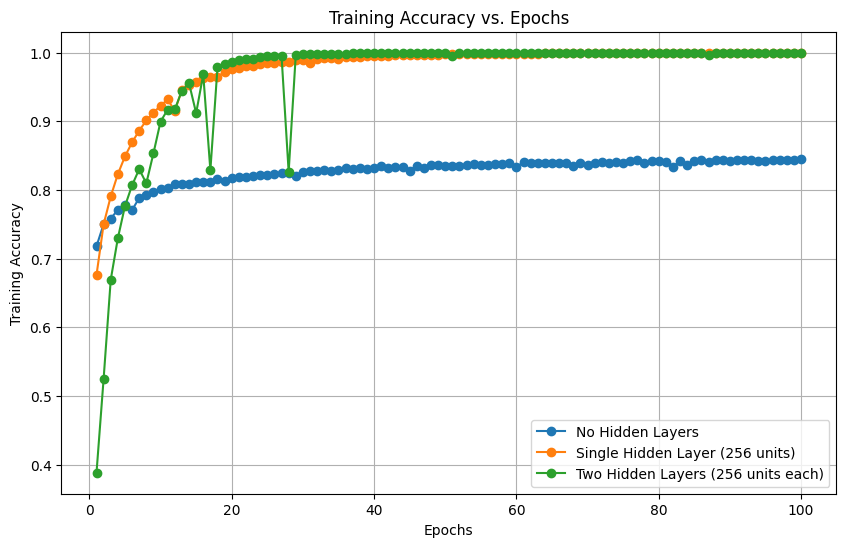

In [ ]:
# TASK 3.1:
# create three different models: (1) an MLP with no hidden layers, i.e., it directly maps the inputs
# to outputs, (2) an MLP with a single hidden layer having 256 units and ReLU activations, (3) an MLP with 2
# hidden layers each having 256 units with ReLU activations. It should be noted that since we want to perform
# classification, all of these models should have a softmax layer at the end. After training, compare the test
# accuracy of these three models on the OrganAMNIST dataset. Comment on how non-linearity and network
# depth affects the accuracy. Are the results that we obtain expected?


# Model 1: No hidden layers
mlp_no_hidden = MLP(input_size=784, hidden_layers=[], output_size=11, activation_fn='relu', initializer='random')
tacc1, test_acc1 = mlp_no_hidden.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, learning_rate=0.01, X_test = X_test, y_test = y_test_one_hot)

# Model 2: Single hidden layer with 256 units
mlp_single_hidden = MLP(input_size=784, hidden_layers=[256], output_size=11, activation_fn='relu', initializer='random')
tacc2, test_acc2 = mlp_single_hidden.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, learning_rate=0.01, X_test = X_test, y_test = y_test_one_hot)

# Model 3: Two hidden layers with 256 units each
mlp_two_hidden = MLP(input_size=784, hidden_layers=[256, 256], output_size=11, activation_fn='relu', initializer='random')
tacc3, test_acc3 = mlp_two_hidden.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, learning_rate=0.01, X_test = X_test, y_test = y_test_one_hot)

# Predict on test data
y_pred_no_hidden = mlp_no_hidden.predict(X_test)
y_pred_single_hidden = mlp_single_hidden.predict(X_test)
y_pred_two_hidden = mlp_two_hidden.predict(X_test)

# Compute accuracy, for each of no hidden, single, and two hidden layers
acc_no_hidden = evaluate_acc(np.argmax(y_test_one_hot, axis=1), y_pred_no_hidden)
acc_single_hidden = evaluate_acc(np.argmax(y_test_one_hot, axis=1), y_pred_single_hidden)
acc_two_hidden = evaluate_acc(np.argmax(y_test_one_hot, axis=1), y_pred_two_hidden)

# Print the test acc for each of them with 2 decimal places, this can then be plotted
print(f"Model 1 (No Hidden Layers) Test Accuracy: {acc_no_hidden * 100:.2f}%")
print(f"Model 2 (Single Hidden Layer) Test Accuracy: {acc_single_hidden * 100:.2f}%")
print(f"Model 3 (Two Hidden Layers) Test Accuracy: {acc_two_hidden * 100:.2f}%")

# Plot of the training accuracy for no, single, and doubble hidden layers with respect to the epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, 100+1), tacc1, label="No Hidden Layers", marker="o")
plt.plot(range(1, 100+1), tacc2, label="Single Hidden Layer (256 units)", marker="o")
plt.plot(range(1, 100+1), tacc3, label="Two Hidden Layers (256 units each)", marker="o")
plt.title("Training Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.legend()
plt.grid(True)
plt.show()

Epoch 10/100: Train Accuracy = 79.86%, Test Accuracy = 62.96%
Epoch 20/100: Train Accuracy = 81.55%, Test Accuracy = 62.32%
Epoch 30/100: Train Accuracy = 82.47%, Test Accuracy = 62.17%
Epoch 40/100: Train Accuracy = 83.33%, Test Accuracy = 61.74%
Epoch 50/100: Train Accuracy = 83.68%, Test Accuracy = 61.50%
Epoch 60/100: Train Accuracy = 83.89%, Test Accuracy = 60.93%
Epoch 70/100: Train Accuracy = 84.01%, Test Accuracy = 60.67%
Epoch 80/100: Train Accuracy = 84.14%, Test Accuracy = 60.37%
Epoch 90/100: Train Accuracy = 84.27%, Test Accuracy = 60.08%
Epoch 100/100: Train Accuracy = 84.51%, Test Accuracy = 59.97%
Epoch 10/100: Train Accuracy = 95.62%, Test Accuracy = 72.47%
Epoch 20/100: Train Accuracy = 98.59%, Test Accuracy = 72.89%
Epoch 30/100: Train Accuracy = 99.47%, Test Accuracy = 73.20%
Epoch 40/100: Train Accuracy = 99.75%, Test Accuracy = 73.14%
Epoch 50/100: Train Accuracy = 99.89%, Test Accuracy = 73.28%
Epoch 60/100: Train Accuracy = 99.92%, Test Accuracy = 73.43%
Epoch 7

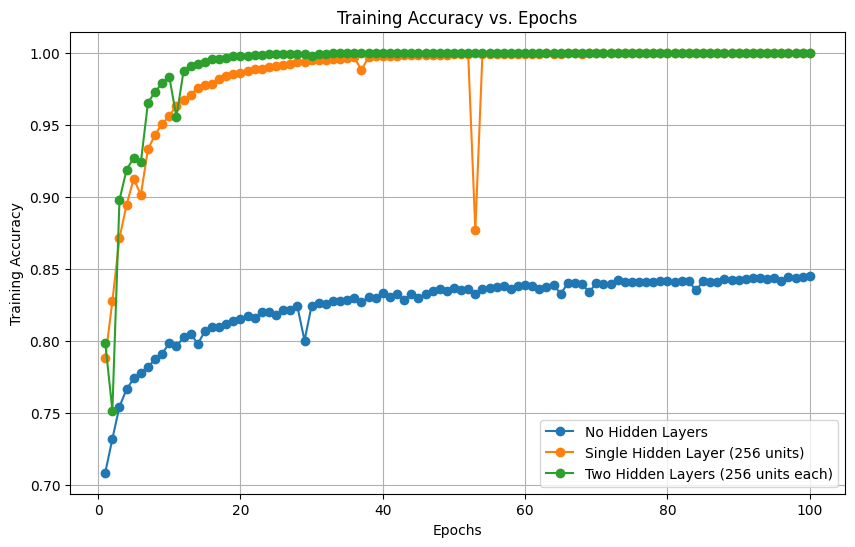

In [38]:
# Train with Xavier weights initialization


# Model 1: No hidden layers
mlp_no_hidden = MLP(input_size=784, hidden_layers=[], output_size=11, activation_fn='relu', initializer='xavier')
tacc1, test_acc1 = mlp_no_hidden.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, learning_rate=0.01, X_test = X_test, y_test = y_test_one_hot)

# Model 2: Single hidden layer with 256 units
mlp_single_hidden = MLP(input_size=784, hidden_layers=[256], output_size=11, activation_fn='relu', initializer='xavier')
tacc2, test_acc2 = mlp_single_hidden.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, learning_rate=0.01, X_test = X_test, y_test = y_test_one_hot)

# Model 3: Two hidden layers with 256 units each
mlp_two_hidden = MLP(input_size=784, hidden_layers=[256, 256], output_size=11, activation_fn='relu', initializer='xavier')
tacc3, test_acc3 = mlp_two_hidden.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, learning_rate=0.01, X_test = X_test, y_test = y_test_one_hot)

# Predict on test data
y_pred_no_hidden = mlp_no_hidden.predict(X_test)
y_pred_single_hidden = mlp_single_hidden.predict(X_test)
y_pred_two_hidden = mlp_two_hidden.predict(X_test)

# Compute accuracy
acc_no_hidden = evaluate_acc(np.argmax(y_test_one_hot, axis=1), y_pred_no_hidden)
acc_single_hidden = evaluate_acc(np.argmax(y_test_one_hot, axis=1), y_pred_single_hidden)
acc_two_hidden = evaluate_acc(np.argmax(y_test_one_hot, axis=1), y_pred_two_hidden)

# Print test acc
print(f"Model 1 (No Hidden Layers) Test Accuracy: {acc_no_hidden * 100:.2f}%")
print(f"Model 2 (Single Hidden Layer) Test Accuracy: {acc_single_hidden * 100:.2f}%")
print(f"Model 3 (Two Hidden Layers) Test Accuracy: {acc_two_hidden * 100:.2f}%")

# Plot training accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, 100+1), tacc1, label="No Hidden Layers", marker="o")
plt.plot(range(1, 100+1), tacc2, label="Single Hidden Layer (256 units)", marker="o")
plt.plot(range(1, 100+1), tacc3, label="Two Hidden Layers (256 units each)", marker="o")
plt.title("Training Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# 3.2

Epoch 10/100: Train Accuracy = 89.44%, Test Accuracy = 69.52%
Epoch 20/100: Train Accuracy = 98.63%, Test Accuracy = 71.97%
Epoch 30/100: Train Accuracy = 99.77%, Test Accuracy = 72.01%
Epoch 40/100: Train Accuracy = 99.95%, Test Accuracy = 72.22%
Epoch 50/100: Train Accuracy = 99.97%, Test Accuracy = 72.21%
Epoch 60/100: Train Accuracy = 99.99%, Test Accuracy = 72.28%
Epoch 70/100: Train Accuracy = 99.99%, Test Accuracy = 72.30%
Epoch 80/100: Train Accuracy = 100.00%, Test Accuracy = 72.31%
Epoch 90/100: Train Accuracy = 100.00%, Test Accuracy = 72.33%
Epoch 100/100: Train Accuracy = 100.00%, Test Accuracy = 72.40%
Epoch 10/100: Train Accuracy = 86.09%, Test Accuracy = 67.41%
Epoch 20/100: Train Accuracy = 96.63%, Test Accuracy = 70.37%
Epoch 30/100: Train Accuracy = 96.76%, Test Accuracy = 70.30%
Epoch 40/100: Train Accuracy = 99.85%, Test Accuracy = 70.47%
Epoch 50/100: Train Accuracy = 99.97%, Test Accuracy = 70.76%
Epoch 60/100: Train Accuracy = 99.99%, Test Accuracy = 70.85%
Epoc

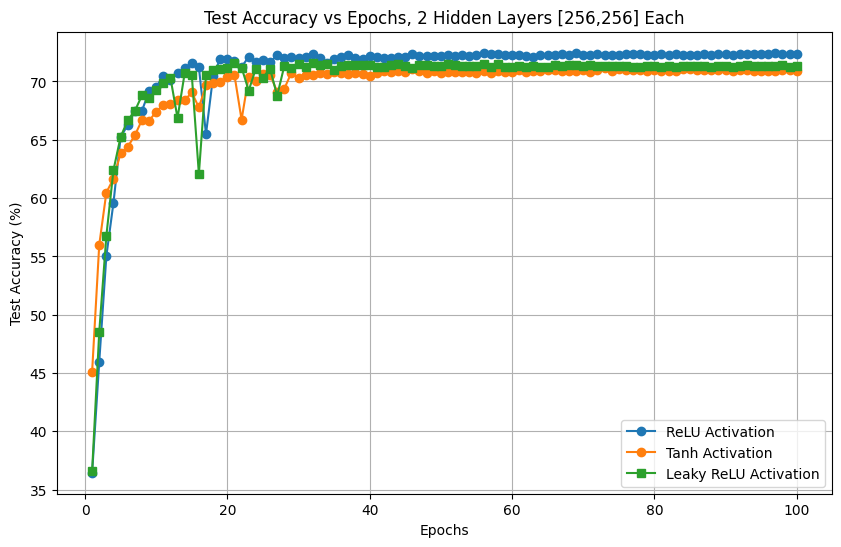

In [39]:
# TASK 3.2:
# Take the last model above, the one with 2 hidden layers, and create two different copies of it in which the
# activations are now tanh and Leaky-ReLU. After training these two models compare their test accuracies with
# model having ReLU activations. Comment on the performances of these models: which one is better and why?
# Are certain activations better than others? If  results are not as we expected, what could be the reason?

# Initialize models
mlp_relu = MLP(input_size=784, hidden_layers=[256, 256], output_size=11, activation_fn='relu')
mlp_tanh = MLP(input_size=784, hidden_layers=[256, 256], output_size=11, activation_fn='tanh')
mlp_leaky_relu = MLP(input_size=784, hidden_layers=[256, 256], output_size=11, activation_fn='leaky_relu')

training_acc_relu, test_acc1 = mlp_relu.fit(X_train, y_train_one_hot, 100, 32, 0.01, X_test, y_test_one_hot)
training_acc_tanh, test_acc2 = mlp_tanh.fit(X_train, y_train_one_hot, 100, 32, 0.01, X_test, y_test_one_hot)
training_acc_leaky_relu, test_acc3 = mlp_leaky_relu.fit(X_train, y_train_one_hot, 100, 32, 0.01, X_test, y_test_one_hot)

# Plot test accuracy vs epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, 100 + 1), np.array(test_acc1) * 100, label='ReLU Activation', marker='o')
plt.plot(range(1, 100 + 1), np.array(test_acc2) * 100, label='Tanh Activation', marker='o')
plt.plot(range(1, 100 + 1), np.array(test_acc3) * 100, label='Leaky ReLU Activation', marker='s')
plt.title('Test Accuracy vs Epochs, 2 Hidden Layers [256,256] Each')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.grid()
plt.show()

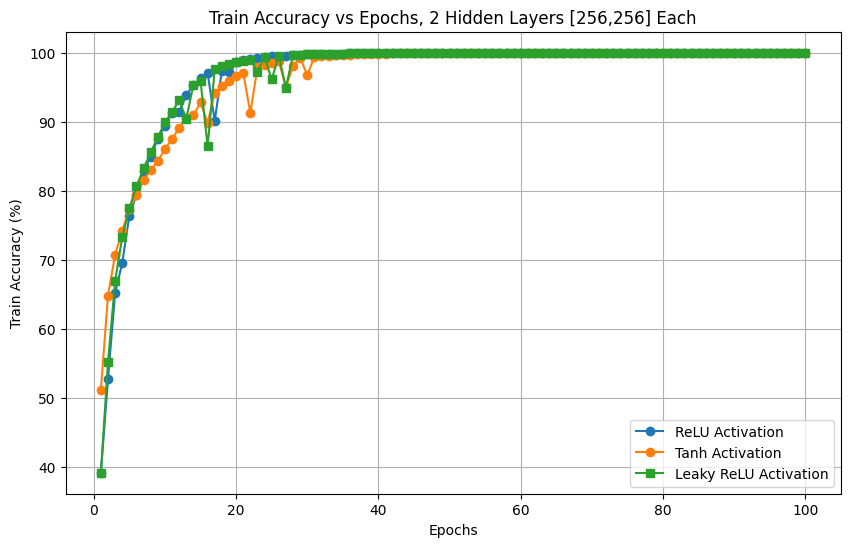

In [42]:
# Plot train accuracy vs epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, 100 + 1), np.array(training_acc_relu) * 100, label='ReLU Activation', marker='o')
plt.plot(range(1, 100 + 1), np.array(training_acc_tanh) * 100, label='Tanh Activation', marker='o')
plt.plot(range(1, 100 + 1), np.array(training_acc_leaky_relu) * 100, label='Leaky ReLU Activation', marker='s')
plt.title('Train Accuracy vs Epochs, 2 Hidden Layers [256,256] Each')
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy (%)')
plt.legend()
plt.grid()
plt.show()

# 3.3

In [40]:
# TASK 3.3:
# Create an MLP with 2 hidden layers each having 256 units with ReLU activations as above. However, this
# time, independently add L1 and L2 regularization to the network and train the MLP in this way. How does
# these regularizations affect the accuracy? This proportion can be varied as a tunable hyperparameter that can be
# explored as part of other project requirements.

# Model 1: No reg
mlp_no_reg = MLP(input_size=784, hidden_layers=[], output_size=11, activation_fn='relu', initializer='random')
tacc1, test_acc1 = mlp_no_reg.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, learning_rate=0.01, X_test = X_test, y_test = y_test_one_hot)

# Model 2: L1 reg = 0.01
mlp_l1_1 = MLP(input_size=784, hidden_layers=[256], output_size=11, activation_fn='relu', initializer='random', reg_type='L1', reg_lambda= 0.01)
tacc2, test_acc2 = mlp_l1_1.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, learning_rate=0.01, X_test = X_test, y_test = y_test_one_hot)

# Model 3: L1 reg = 0.1
mlp_l1_2 = MLP(input_size=784, hidden_layers=[256, 256], output_size=11, activation_fn='relu', initializer='random', reg_type='L1', reg_lambda= 0.1)
tacc3, test_acc3 = mlp_l1_2.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, learning_rate=0.01, X_test = X_test, y_test = y_test_one_hot)

# Model 4: L2 reg = 0.01
mlp_l2_1 = MLP(input_size=784, hidden_layers=[256], output_size=11, activation_fn='relu', initializer='random', reg_type='L2', reg_lambda= 0.01)
tacc4, test_acc4 = mlp_l2_1.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, learning_rate=0.01, X_test = X_test, y_test = y_test_one_hot)

# Model 5: L2 reg = 0.1
mlp_l2_2 = MLP(input_size=784, hidden_layers=[256, 256], output_size=11, activation_fn='relu', initializer='random', reg_type='L2', reg_lambda= 0.1)
tacc5, test_acc5 = mlp_l2_2.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, learning_rate=0.01, X_test = X_test, y_test = y_test_one_hot)

# Plot test accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, 100+1), test_acc1, label="no reg", marker="o")
plt.plot(range(1, 100+1), test_acc2, label="L1 = 0.01", marker="o")
plt.plot(range(1, 100+1), test_acc3, label="L1 = 0.1", marker="o")
plt.plot(range(1, 100+1), test_acc4, label="L2 = 0.01", marker="o")
plt.plot(range(1, 100+1), test_acc5, label="L2 = 0.1", marker="o")
plt.title("Test Accuracy vs. Epochs, 2 hidden layers + relu + regularization")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()

Epoch 10/100: Train Accuracy = 80.25%, Test Accuracy = 63.35%
Epoch 20/100: Train Accuracy = 81.97%, Test Accuracy = 62.28%
Epoch 30/100: Train Accuracy = 82.76%, Test Accuracy = 61.96%
Epoch 40/100: Train Accuracy = 82.98%, Test Accuracy = 61.53%
Epoch 50/100: Train Accuracy = 83.65%, Test Accuracy = 61.22%
Epoch 60/100: Train Accuracy = 83.96%, Test Accuracy = 60.65%


KeyboardInterrupt: 

# 3.4

Epoch 10/100: Train Accuracy = 71.51%, Test Accuracy = 60.03%
Epoch 20/100: Train Accuracy = 70.34%, Test Accuracy = 58.62%
Epoch 30/100: Train Accuracy = 74.45%, Test Accuracy = 59.84%
Epoch 40/100: Train Accuracy = 80.05%, Test Accuracy = 62.77%
Epoch 50/100: Train Accuracy = 75.22%, Test Accuracy = 59.92%
Epoch 60/100: Train Accuracy = 81.33%, Test Accuracy = 62.61%
Epoch 70/100: Train Accuracy = 81.63%, Test Accuracy = 62.66%
Epoch 80/100: Train Accuracy = 77.82%, Test Accuracy = 59.34%
Epoch 90/100: Train Accuracy = 81.84%, Test Accuracy = 61.80%
Epoch 100/100: Train Accuracy = 82.29%, Test Accuracy = 61.78%
Epoch 10/100: Train Accuracy = 79.07%, Test Accuracy = 66.39%
Epoch 20/100: Train Accuracy = 52.79%, Test Accuracy = 44.68%
Epoch 30/100: Train Accuracy = 68.63%, Test Accuracy = 54.90%
Epoch 40/100: Train Accuracy = 92.25%, Test Accuracy = 71.67%
Epoch 50/100: Train Accuracy = 93.22%, Test Accuracy = 71.93%
Epoch 60/100: Train Accuracy = 91.77%, Test Accuracy = 71.12%
Epoch 7

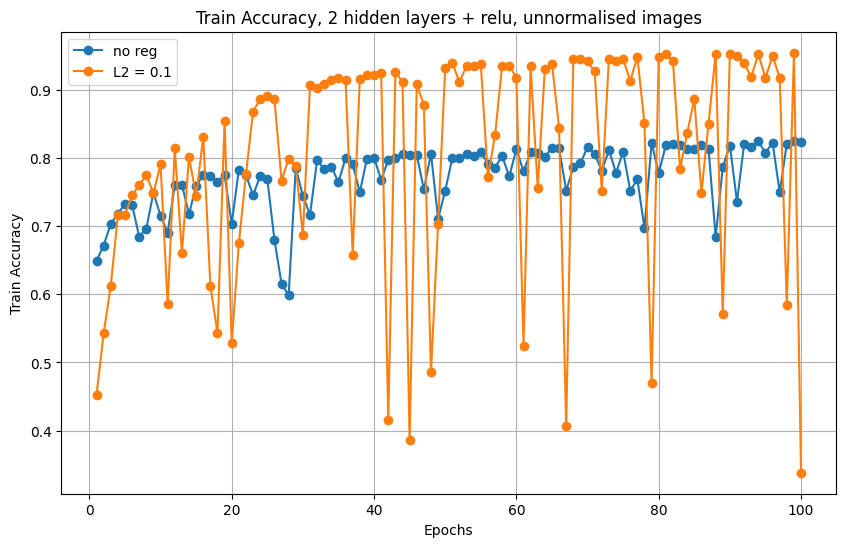

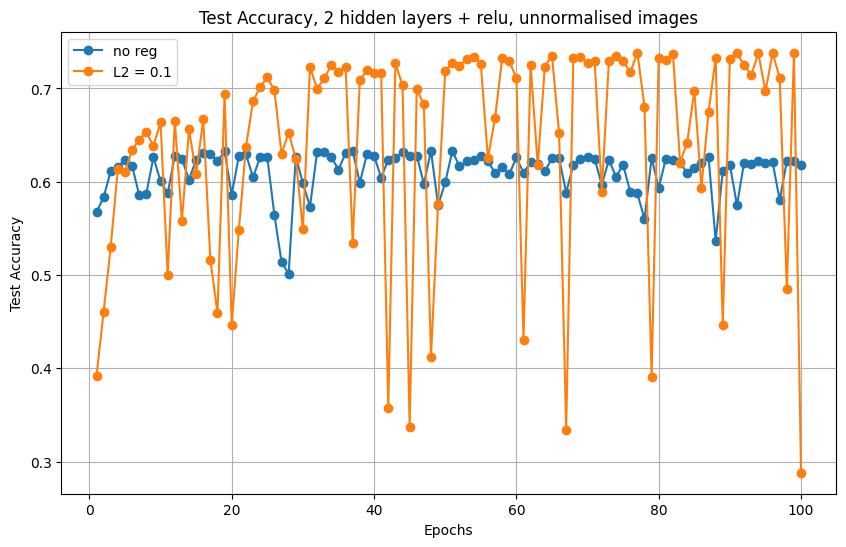

In [ ]:
# TASK 3.4:
# Create an MLP with 2 hidden layers each having 256 units with ReLU activations as above. However, this time,
# train it with unnormalized images. How does this affect the accuracy?

# Model 1: 2 hidden layers, relu, no reg
mlp_relu = MLP(input_size=784, hidden_layers=[], output_size=11, activation_fn='relu')
tacc1, test_acc1 = mlp_relu.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, learning_rate=0.01, X_test = X_test, y_test = y_test_one_hot)

# Model 2: 2 hidden layers, relu, L2 reg
mlp_l2_reg = MLP(input_size=784, hidden_layers=[256], output_size=11, activation_fn='relu', initializer='random', reg_type='L2', reg_lambda=0.1)
tacc2, test_acc2 = mlp_l2_reg.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, learning_rate=0.01, X_test = X_test, y_test = y_test_one_hot)

# Plot training accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, 100+1), tacc1, label="no reg", marker="o")
plt.plot(range(1, 100+1), tacc2, label="L2 = 0.1", marker="o")
plt.title("Train Accuracy, 2 hidden layers + relu, unnormalised images")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plot test accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, 100+1), test_acc1, label="no reg", marker="o")
plt.plot(range(1, 100+1), test_acc2, label="L2 = 0.1", marker="o")
plt.title("Test Accuracy, 2 hidden layers + relu, unnormalised images")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# 3.5

100%|██████████| 38.2M/38.2M [00:02<00:00, 13.9MB/s]


Using downloaded and verified file: /root/.medmnist/organamnist.npz
Epoch 1/3, Test Accuracy: 11.03%
Epoch 2/3, Test Accuracy: 11.05%
Epoch 3/3, Test Accuracy: 11.05%


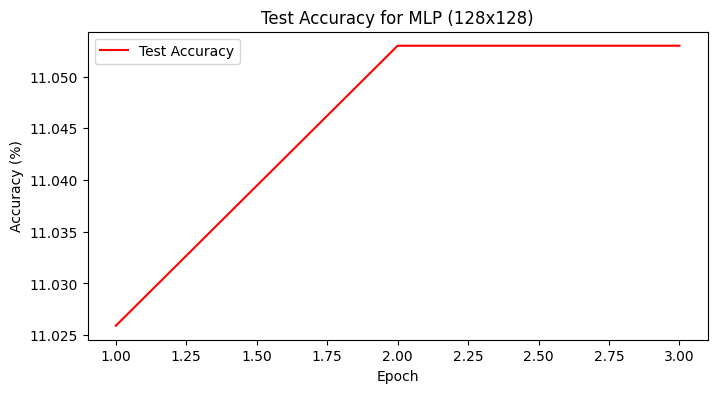

In [ ]:
# Load the data
data_transform_128 = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset_128 = OrganAMNIST(split="train", download=True, transform=data_transform_128)
test_dataset_128 = OrganAMNIST(split="test", download=True, transform=data_transform_128)

train_loader_128 = DataLoader(train_dataset_128, batch_size=32, shuffle=True)
test_loader_128 = DataLoader(test_dataset_128, batch_size=32, shuffle=False)

# Convert dataset to numpy arrays
def dataset_to_numpy(loader):
    X_list, y_list = [], []
    for images, labels in loader:
        X_list.append(images.view(images.size(0), -1).numpy())
        y_list.append(labels.numpy())
    return np.concatenate(X_list), np.concatenate(y_list)

X_train, y_train = dataset_to_numpy(train_loader_128)
X_test, y_test = dataset_to_numpy(test_loader_128)

# Define the MLP Model, we can remake it for this task since
#for some reason the backpropogation is bugging us
class SimpleMLP:
  #change input size as this time we are dealing with 128x128 image
    def __init__(self, input_size=128*128, hidden1=512, hidden2=256, output_size=11, lr=0.001):
        np.random.seed(42)  # For reproducibility
        self.lr = lr

        # Initialize weights and biases with reduced variance
        self.W1 = np.random.randn(input_size, hidden1) * 0.005
        self.b1 = np.zeros((1, hidden1))
        self.W2 = np.random.randn(hidden1, hidden2) * 0.005
        self.b2 = np.zeros((1, hidden2))
        self.W3 = np.random.randn(hidden2, output_size) * 0.005
        self.b3 = np.zeros((1, output_size))

    def relu(self, x):
        return np.maximum(0.01 * x, x)  # Leaky ReLU to avoid dying ReLU

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0.01)  # Derivative for Leaky ReLU

    def softmax(self, z):
        # Numerically stable softmax
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        self.Z1 = X.dot(self.W1) + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = self.A1.dot(self.W2) + self.b2
        self.A2 = self.relu(self.Z2)
        self.Z3 = self.A2.dot(self.W3) + self.b3
        self.A3 = self.softmax(self.Z3)
        return self.A3

    def compute_loss(self, Y_hat, Y):
        m = Y.shape[0]
        epsilon = 1e-10  # Adding a small epsilon value to prevent log(0)
        log_likelihood = -np.log(Y_hat[range(m), Y] + epsilon)
        loss = np.sum(log_likelihood) / m
        return loss

    def backward(self, X, Y):
        m = X.shape[0]
        Y_hat = self.A3

        # Derivative of loss with respect to Z3
        dZ3 = Y_hat
        dZ3[range(m), Y] -= 1
        dZ3 /= m

        # Gradients for W3 and b3
        dW3 = self.A2.T.dot(dZ3)
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        # Backpropagate through second layer
        dA2 = dZ3.dot(self.W3.T)
        dZ2 = dA2 * self.relu_derivative(self.Z2)

        # Gradients for W2 and b2
        dW2 = self.A1.T.dot(dZ2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        # Backpropagate through first layer
        dA1 = dZ2.dot(self.W2.T)
        dZ1 = dA1 * self.relu_derivative(self.Z1)

        # Gradients for W1 and b1
        dW1 = X.T.dot(dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        # Clip gradients to prevent exploding gradients
        clip_value = 1.0
        dW3 = np.clip(dW3, -clip_value, clip_value)
        dW2 = np.clip(dW2, -clip_value, clip_value)
        dW1 = np.clip(dW1, -clip_value, clip_value)

        # Update weights and biases
        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def train(self, X, Y, X_test, Y_test, epochs=3, batch_size=32):
        test_accuracies = []

        for epoch in range(epochs):
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i + batch_size]
                Y_batch = Y[i:i + batch_size]

                # Forward and Backward pass
                self.forward(X_batch)
                self.backward(X_batch, Y_batch)

            # Evaluate on test set
            y_pred = self.predict(X_test)
            test_accuracy = np.mean(Y_test == y_pred) * 100
            test_accuracies.append(test_accuracy)
            print(f"Epoch {epoch + 1}/{epochs}, Test Accuracy: {test_accuracy:.2f}%")

        return test_accuracies

    def predict(self, X):
        Y_hat = self.forward(X)
        return np.argmax(Y_hat, axis=1)

# Train the MLP and track test accuracy
mlp_model = SimpleMLP(lr=0.001)
test_accuracies = mlp_model.train(X_train, y_train, X_test, y_test, epochs=3)

# Plotting the Test Accuracy for each epoch
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy', color='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy for MLP (128x128)')
plt.legend()
plt.show()

# 3.6 onwards

##3.6

Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz
Epoch 1, Loss: 0.3126, Test Accuracy: 85.63%
Epoch 2, Loss: 0.0679, Test Accuracy: 87.76%
Epoch 3, Loss: 0.0292, Test Accuracy: 88.02%
*******************************************************
Training time for this model: 218.97 seconds


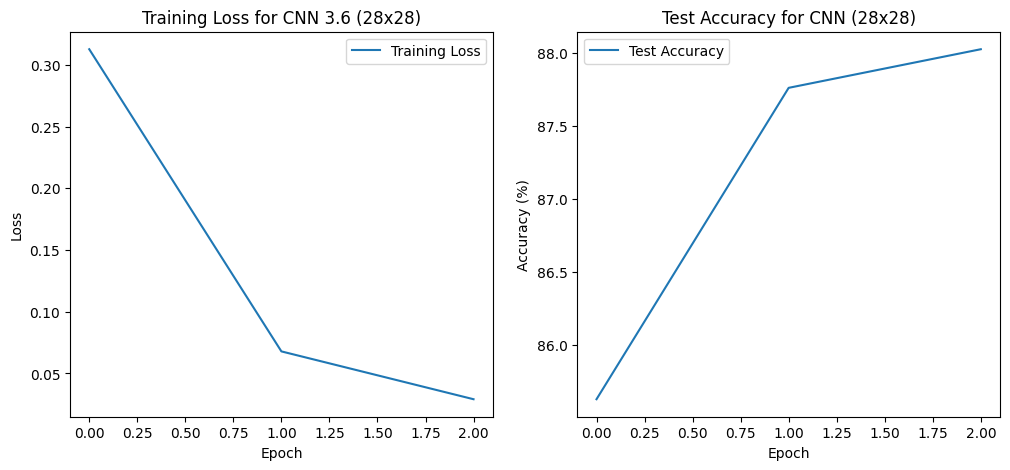

In [ ]:
# Load the dataset and apply  transformations(this is like task 1, but here we can adjust anything if we are facing issue with image transformation)
data_transform_28 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset_28 = OrganAMNIST(split="train", download=True, transform=data_transform_28)
test_dataset_28 = OrganAMNIST(split="test", download=True, transform=data_transform_28)


train_loader_28 = DataLoader(train_dataset_28, batch_size=32, shuffle=True)
test_loader_28 = DataLoader(test_dataset_28, batch_size=32, shuffle=False)

#**************************************************************************#

#our CNNModel as a class
class CNNModel(nn.Module):
    def __init__(self, num_classes=11):
        super(CNNModel, self).__init__()
        #set the convolutional 2d layers with a filter size of 3, stride of 1 an padding of 1
        #but for our 2nd convolutional layer, make it 32 to 64 instead
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        #we can use either average or max pooling, but maxpool seems more effective
        #as it will be better from startlayer to end layer, with a filter size of 2,stride2, and no padding

        #ta said it is ok to add pooling but not required here
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        #set the image dimension for 28x28
        self.fc1 = nn.Linear(64 * 7 * 7, 256)  # for 28x28 images
        self.fc2 = nn.Linear(256, num_classes)
        #we need to apply ReLU to all o it
        self.relu = nn.ReLU()

    #using our forward pass function, we will pool the relus of the convolutional filter
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        #set the view
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#*******************************************************************************************************************************#
# Initialize and Train the CNN Model
cnn_model = CNNModel()

criterion = nn.CrossEntropyLoss()
#NOTE: SGD OPTIMIZER GIVES US 61.03% accuracy, we can use
#Adam instead to see if it boosts it

#Here we chose a lr of 0.001 because from the LR choice justification it seems best!
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Training loop for 3.6
train_losses, test_accuracies = [], []

start_time = time.time()
for epoch in range(3):
  #intialize cnn model in train mode, later we will set to evaluation mode
    cnn_model.train()
    running_loss = 0.0
    for images, labels in train_loader_28:
        optimizer.zero_grad()
        outputs = cnn_model(images)
        labels = labels.view(-1).long()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Track average training loss for the epoch
    train_losses.append(running_loss / len(train_loader_28))

    # Evaluate on test set
    cnn_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader_28:
            outputs = cnn_model(images)
            _, predicted = torch.max(outputs, 1)
            # Ensure labels are 1D(imp, the 400% accuracy discrepency was coming from this!!!)
            labels = labels.view(-1).long()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Track test accuracy for the epoch
    test_accuracy = (correct / total) * 100
    test_accuracies.append(test_accuracy)
    #then while the loop is running, print each of the epoch, the train loss, and the test accuracy
    #eg.) Epoch ____, Loss: ____, Test Accuracy: ____
    #for each line, this is good because if an epoch isnt being printed or if there is no accuracy,
    #we will know there is a error
    print(f'Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}, Test Accuracy: {test_accuracy:.2f}%')

print("*"*55)
# Track training time for the model, we can later compare these to the other tasks 3.7+
end_time = time.time()
training_time = end_time - start_time
#print the training time
print(f'Training time for this model: {training_time:.2f} seconds')

#*********************************************************************************************************#
# Plot Training Loss and Test Accuracy

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss for CNN 3.6 (28x28)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy for CNN (28x28)')
plt.legend()
plt.show()

## Test accuracy for different LR(28x28 3.6 model)

[LR=0.001] Epoch 1, Loss: 0.3151, Test Accuracy: 86.96%
[LR=0.001] Epoch 2, Loss: 0.0635, Test Accuracy: 88.61%
[LR=0.001] Epoch 3, Loss: 0.0311, Test Accuracy: 87.98%
[LR=0.01] Epoch 1, Loss: 0.4778, Test Accuracy: 80.23%
[LR=0.01] Epoch 2, Loss: 0.2169, Test Accuracy: 80.45%
[LR=0.01] Epoch 3, Loss: 0.1657, Test Accuracy: 79.04%
[LR=0.1] Epoch 1, Loss: 7.8573, Test Accuracy: 18.48%
[LR=0.1] Epoch 2, Loss: 2.3069, Test Accuracy: 18.48%
[LR=0.1] Epoch 3, Loss: 2.3063, Test Accuracy: 18.48%


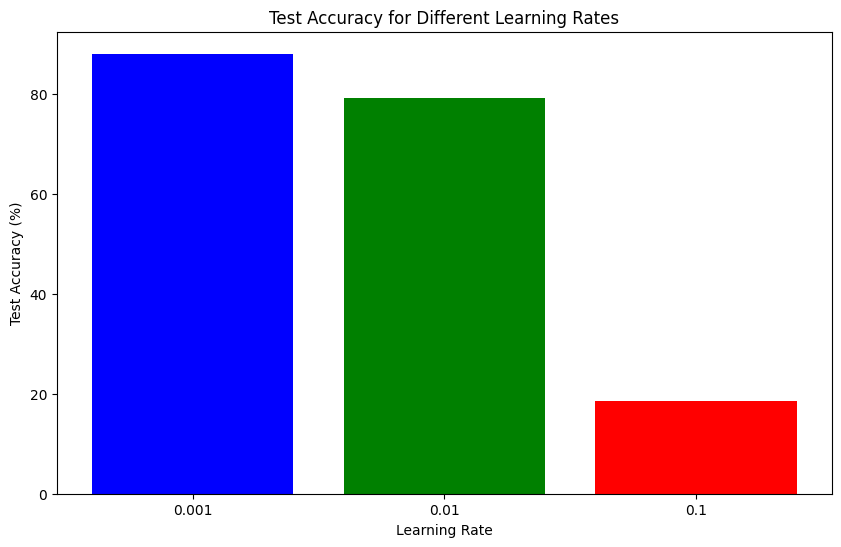

In [ ]:
#to see which LR is best for our model, we can run it for 3 epochs each time but with a different LR
#this is the same in task 3.6 but just changing the LR, based on our results:
#-> we can use the optimal LR, and for the proceeding parts as well

#set different Learning rates
learning_rates = [0.001, 0.01, 0.1]
lr_results = {}

# Loop through each learning rate to train and evaluate the model
for lr in learning_rates:
    # Initialize and Train the CNN Model for Task 3.66 with Different Learning Rates
    #we are calling the same model that we made above
    cnn_model = CNNModel()
    criterion = nn.CrossEntropyLoss()
    #this time instead of having a fixed LR, we will use the stored array of learning rates
    #then each loop we will use a different LR to see which is better
    optimizer = optim.Adam(cnn_model.parameters(), lr=lr)

    train_losses, test_accuracies = [], []

    for epoch in range(3):  # train for 3 epochs
        cnn_model.train()
        running_loss = 0.0
        for images, labels in train_loader_28:
            optimizer.zero_grad()
            outputs = cnn_model(images)
            labels = labels.view(-1).long()  # Ensur thate labels are 1D
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Track average training loss for the epoch
        train_losses.append(running_loss / len(train_loader_28))

        # Evaluate on test set
        cnn_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader_28:
                outputs = cnn_model(images)
                _, predicted = torch.max(outputs, 1)
                # Ensure labels are 1D (imp, the 400% accuracy discrepency was coming from this!!!)
                labels = labels.view(-1).long()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Track test accuracy for the epoch
        test_accuracy = (correct / total) * 100
        test_accuracies.append(test_accuracy)
        print(f'[LR={lr}] Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Store the final test accuracy for comparison
    lr_results[lr] = test_accuracies[-1]

# Plotting accuracies of the Learning Rate
plt.figure(figsize=(10, 6))
#loop through the keys of lr results
plt.bar([str(lr) for lr in lr_results.keys()], lr_results.values(), color=['b', 'g', 'r'])


plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy for Different Learning Rates')
plt.show()

##3.7

Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz
Epoch 1, Loss: 0.3128, Test Accuracy: 83.59%
Epoch 2, Loss: 0.0430, Test Accuracy: 83.38%
Epoch 3, Loss: 0.0177, Test Accuracy: 81.27%
*******************************************************
Training time for this model: 7959.24 seconds


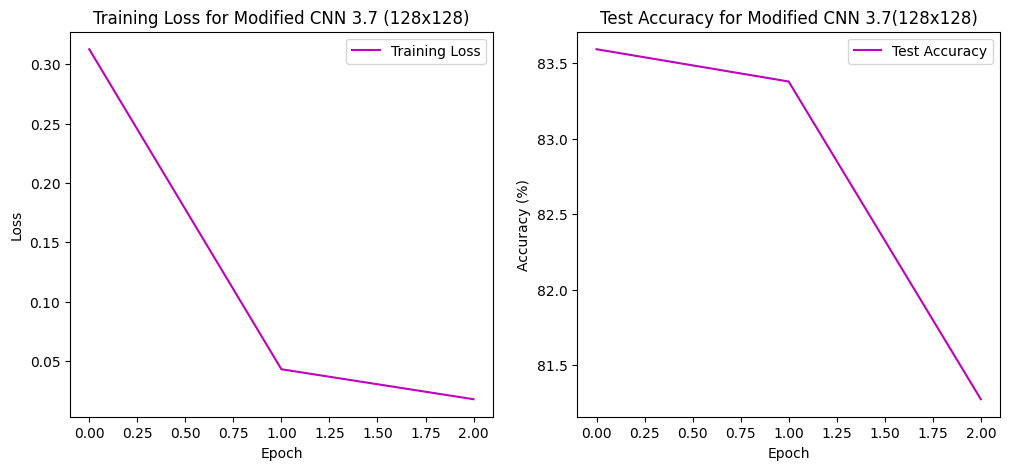

In [ ]:
#3.7 Define and Train Modified CNN  (Using 128x128 Version)

# Load the dataset and apply appropriate transformations

data_transform_128 = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


train_dataset_128 = OrganAMNIST(split="train", download=True, transform=data_transform_128)
test_dataset_128 = OrganAMNIST(split="test", download=True, transform=data_transform_128)


train_loader_128 = DataLoader(train_dataset_128, batch_size=32, shuffle=True)
test_loader_128 = DataLoader(test_dataset_128, batch_size=32, shuffle=False)


class ModifiedCNNModel(nn.Module):
    def __init__(self, num_classes=11):
        super(ModifiedCNNModel, self).__init__()
        #set the convolutional 2d layers with a filter size of 3, stride of 1 an padding of 1
        #but for our 2nd convolutional layer, make it 32 to 64 instead
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        #we can use either average or max pooling, but maxpool seems more effective
        #as it will be better from startlayer to end layer, with a filter size of 2,stride2, and no padding

        #the TA said it is ok to add pooling but not required here
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 32 * 32, 512)  # for 128x128 images
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize and Train the Modified CNN Model for 3.7
modified_cnn_model = ModifiedCNNModel()
#set the criterion to crossEntropyloss, since we are dealing with multiple classes
criterion = nn.CrossEntropyLoss()
#set optimizer to Adam (better choice, play around with RMSsprop if needed)
optimizer = optim.Adam(modified_cnn_model.parameters(), lr=0.001)

train_losses_128, test_accuracies_128 = [], []


start_time = time.time()
#train the CNN model with 3 epochs
for epoch in range(3):
    modified_cnn_model.train()
    running_loss = 0.0
    for images, labels in train_loader_128:
        optimizer.zero_grad()
        outputs = modified_cnn_model(images)
        labels = labels.view(-1).long()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Track average training loss for the epoch by dividing the running loss over the leength of the data train loader
    train_losses_128.append(running_loss / len(train_loader_128))


    modified_cnn_model.eval()
    correct_128 = 0
    total_128 = 0
    with torch.no_grad():
        for images, labels in test_loader_128:
            outputs = modified_cnn_model(images)
            _, predicted = torch.max(outputs, 1)
            # Ensure labels are 1D (imp, the 400% accuracy discrepency was coming from this!!!)
            labels = labels.view(-1).long()
            total_128 += labels.size(0)
            correct_128 += (predicted == labels).sum().item()

    # Track test accuracy for the epoch
    test_accuracy_128 = (correct_128 / total_128) * 100
    test_accuracies_128.append(test_accuracy_128)
    print(f'Epoch {epoch+1}, Loss: {train_losses_128[-1]:.4f}, Test Accuracy: {test_accuracy_128:.2f}%')

print("*"*55)
# Track training time for the model, we can later compare these to the other tasks 3.7+
end_time = time.time()
training_time = end_time - start_time
print(f'Training time for this model: {training_time:.2f} seconds')

#*******************************************************************************************************************#

# Plot Training Loss and Test Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_128, label='Training Loss', color='m')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss for Modified CNN 3.7 (128x128)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies_128, label='Test Accuracy', color='m')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy for Modified CNN 3.7(128x128)')
plt.legend()
plt.show()

##3.8

###3.8 128x128

Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz
Epoch 1, Loss: 0.5952, Test Accuracy: 78.58%
Epoch 2, Loss: 0.4378, Test Accuracy: 79.20%
Epoch 3, Loss: 0.3800, Test Accuracy: 80.12%
*******************************************************
Training time for this model: 5090.01 seconds


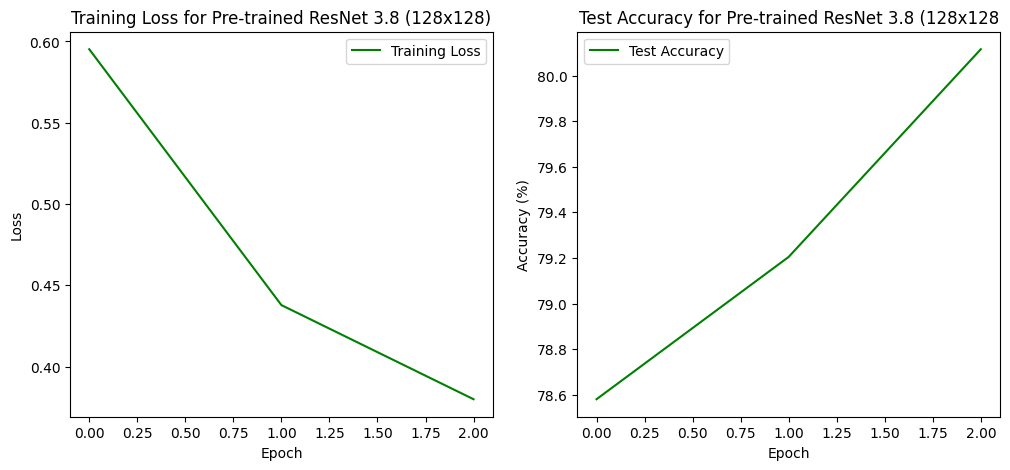

In [ ]:
# Implement Pre-Trained Model for OrganAMNIST
# Load a pre-trained ResNet model

data_transform_128 = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1)),  # Convert single channel to 3 channels by expanding (error was found because it wasnt expanded!)
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for 3 channels
])

train_dataset_128 = OrganAMNIST(split="train", download=True, transform=data_transform_128)
test_dataset_128 = OrganAMNIST(split="test", download=True, transform=data_transform_128)

train_loader_128 = DataLoader(train_dataset_128, batch_size=32, shuffle=True)
test_loader_128 = DataLoader(test_dataset_128, batch_size=32, shuffle=False)

# Load the pre-trained ResNet model that we will use, in this case we will use the ResNet 18, like that suggested by the Ass. description
pretrained_model = models.resnet18(pretrained=True)

# Freeze all convolutional layers
for param in pretrained_model.parameters():
    param.requires_grad = False

# Modify the fullyy connected layers:
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Linear(256, 11)  # 256 fully connected layers and 11 classes in OrganAMNIST
)

# Train only the on the  new fully connected layers
#once again, using Adam cause it helps boost the accuracy, we could also use RMSprop as we know that can also give high accuracy for
#this particular dataset
optimizer = optim.Adam(pretrained_model.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses_pretrained, test_accuracies_pretrained = [], []

#begin the time so that we know how long it takes to train
start_time = time.time()
# train for 3 epochs (1 to 3)
for epoch in range(3):

    pretrained_model.train()
    running_loss = 0.0
    for images, labels in train_loader_128:
        optimizer.zero_grad()
        # check thast  label is 1D, if we have any issue we can play around with this to ensure the dimension is fine
        labels = labels.view(-1).long()

        outputs = pretrained_model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    #calculate the training loss by dividing the run loss over the length of the train data loader (28)
    train_losses_pretrained.append(running_loss / len(train_loader_128))


    #now we will do the evaluations, idea from the colabs provided
    pretrained_model.eval()
    correct_pretrained = 0
    total_pretrained = 0
    with torch.no_grad():
        for images, labels in test_loader_128:
            outputs = pretrained_model(images)
            _, predicted = torch.max(outputs, 1)
            labels = labels.view(-1).long()
            total_pretrained += labels.size(0)
            correct_pretrained += (predicted == labels).sum().item()

    # Track test accuracy for each of the epochs epoch, save them then plot them
    test_accuracy_pretrained = (correct_pretrained / total_pretrained) * 100
    test_accuracies_pretrained.append(test_accuracy_pretrained)
    print(f'Epoch {epoch+1}, Loss: {train_losses_pretrained[-1]:.4f}, Test Accuracy: {test_accuracy_pretrained:.2f}%')

print("*" * 55)
# Track training time for the model, we can later compare these to the other tasks 3.7+
end_time = time.time()
training_time = end_time - start_time
print(f'Training time for this model: {training_time:.2f} seconds')

#*******************************************************************************************************************#

# Plot Training Loss and Test Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_pretrained, label='Training Loss', color='g')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss for Pre-trained ResNet 3.8 (128x128)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies_pretrained, label='Test Accuracy', color='g')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy for Pre-trained ResNet 3.8 (128x128')
plt.legend()
plt.show()


##Justification of conected layers(pre-trained CNN)

Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz
[Single Layer] Epoch 1, Loss: 1.0794, Test Accuracy: 64.06%
[Single Layer] Epoch 2, Loss: 0.8725, Test Accuracy: 64.94%
[Single Layer] Epoch 3, Loss: 0.8480, Test Accuracy: 65.70%
[Single Layer] Training time for this model: 494.93 seconds
[Two Layers] Epoch 1, Loss: 0.9941, Test Accuracy: 63.96%
[Two Layers] Epoch 2, Loss: 0.8021, Test Accuracy: 67.18%
[Two Layers] Epoch 3, Loss: 0.7357, Test Accuracy: 67.48%
[Two Layers] Training time for this model: 495.26 seconds
[Three Layers] Epoch 1, Loss: 1.0040, Test Accuracy: 66.67%
[Three Layers] Epoch 2, Loss: 0.8026, Test Accuracy: 66.95%
[Three Layers] Epoch 3, Loss: 0.7306, Test Accuracy: 68.45%
[Three Layers] Training time for this model: 512.08 seconds
*******************************************************


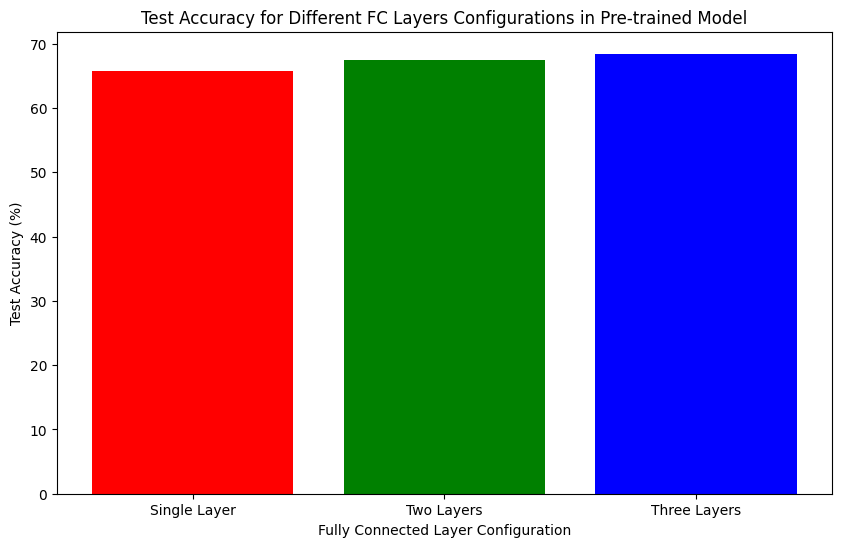

In [ ]:
#we are asked to justify the choice of the FC (fully connected) layers, so the one we are running by default
#is the 256 as specfied by assignment, but now lets check single, two, and three layer. each increasing complexity
#then choose the optimal one
# Load the dataset and apply transformations (convert grayscale to 3-channel 3z3 RGB)
data_transform_28 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1)),  # Expand single channel to 3 channels
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset_28 = OrganAMNIST(split="train", download=True, transform=data_transform_28)
test_dataset_28 = OrganAMNIST(split="test", download=True, transform=data_transform_28)

# Updated DataLoader with drop_last=True
train_loader_28 = DataLoader(train_dataset_28, batch_size=32, shuffle=True, drop_last=True)
test_loader_28 = DataLoader(test_dataset_28, batch_size=32, shuffle=False, drop_last=True)

# Variations of the Fully Connected Layers
fc_variations = {
    'Single Layer': nn.Sequential(
        nn.Linear(models.resnet18().fc.in_features, 11)  # Single FC layer for classification
    ),
    'Two Layers': nn.Sequential(
        nn.Linear(models.resnet18().fc.in_features, 256),
        nn.ReLU(),
        nn.Linear(256, 11)  # Original 2-layer configuration
    ),
    'Three Layers': nn.Sequential(
        nn.Linear(models.resnet18().fc.in_features, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 11)  # Increased complexity with 3 FC layers
    )
}

fc_results = {}

# Loop through each fully connected layer configuration
for variation_name, fc_layers in fc_variations.items():
    # Load a pre-trained ResNet model
    pretrained_model = models.resnet18(pretrained=True)

    # Freeze all convolutional layers
    for param in pretrained_model.parameters():
        param.requires_grad = False

    # Assign modified FC layers to the pretrained model
    pretrained_model.fc = fc_layers

    # Train only the new fully connected layers, once again using Adam optimizer, (we can play around)
    optimizer = optim.Adam(pretrained_model.fc.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_losses_fc, test_accuracies_fc = [], []

    start_time = time.time()
    # Train for 3 epochs
    for epoch in range(3):
        pretrained_model.train()
        running_loss = 0.0
        for images, labels in train_loader_28:
            if images.size(0) == 1:  # Skip if batch size is 1 (because batch size 1 wouldnt make sense here, it was giving error)
                continue
            optimizer.zero_grad()
            labels = labels.view(-1).long()

            outputs = pretrained_model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Track average training loss for the epoch
        train_losses_fc.append(running_loss / len(train_loader_28))


        pretrained_model.eval()
        correct_fc = 0
        total_fc = 0
        with torch.no_grad():
            for images, labels in test_loader_28:
                if images.size(0) == 1:  # Skip if batch size is 1
                    continue
                outputs = pretrained_model(images)
                _, predicted = torch.max(outputs, 1)
                labels = labels.view(-1).long()
                total_fc += labels.size(0)
                correct_fc += (predicted == labels).sum().item()

        # Track test accuracy for the epoch
        test_accuracy_fc = (correct_fc / total_fc) * 100
        test_accuracies_fc.append(test_accuracy_fc)
        print(f'[{variation_name}] Epoch {epoch + 1}, Loss: {train_losses_fc[-1]:.4f}, Test Accuracy: {test_accuracy_fc:.2f}%')

    # Store final test accuracy for comparison
    fc_results[variation_name] = test_accuracies_fc[-1]

    # Track training time for this FC configuration
    end_time = time.time()
    training_time = end_time - start_time
    print(f'[{variation_name}] Training time for this model: {training_time:.2f} seconds')

print("*" * 55)

# Plotting the Accuracy for Each FC Layer Variation
plt.figure(figsize=(10, 6))
plt.bar(fc_results.keys(), fc_results.values(), color=['r', 'g', 'b'])
plt.xlabel('Fully Connected Layer Configuration')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy for Different FC Layers Configurations in Pre-trained Model')
plt.show()

#from results, we see the three layer with higher accuracy, but we were specified to use 256 in assignment instructions,
#one thing we can note is that, as layers increase, training time does increase aswell, so for the 128x128 model it may
#play a bigger role (we could run it also for 128x128 on the GPU or here, it will take a while but will prob yield a similar trend)

#Creativity

Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz
[SGD] Epoch 1, Loss: 2.2103, Test Accuracy: 35.82%
[SGD] Epoch 2, Loss: 1.6947, Test Accuracy: 45.47%
[SGD] Epoch 3, Loss: 1.2566, Test Accuracy: 56.54%
[Adagrad] Epoch 1, Loss: 0.7099, Test Accuracy: 73.77%
[Adagrad] Epoch 2, Loss: 0.4667, Test Accuracy: 75.84%
[Adagrad] Epoch 3, Loss: 0.4047, Test Accuracy: 74.37%
[RMSprop] Epoch 1, Loss: 0.3322, Test Accuracy: 60.12%
[RMSprop] Epoch 2, Loss: 0.0680, Test Accuracy: 87.88%
[RMSprop] Epoch 3, Loss: 0.0274, Test Accuracy: 88.73%


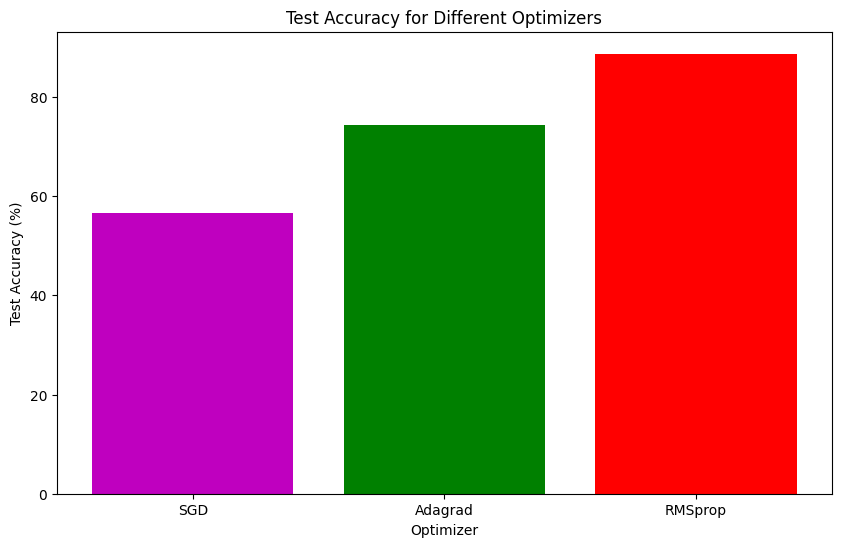

In [ ]:
#for the creativity part, we thought its cool to try different optimizers on the CNN model for task 3.6 (28x28 image size) (shorter time to run)
#we noticed that different optimizers give different results (significantly), so it would be cool to see how different
#optimizing algorthims we learnt during this semesters will differ in terms of accuracy on our models

#Given: The optimizer we used for 3.6 is: Adam, and had an accuracy of 87.66%

#similar to other tasks, load in the data and transform it (we will be using 28x28 as its faster)
data_transform_28 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])



train_dataset_28 = OrganAMNIST(split="train", download=True, transform=data_transform_28)
test_dataset_28 = OrganAMNIST(split="test", download=True, transform=data_transform_28)

train_loader_28 = DataLoader(train_dataset_28, batch_size=32, shuffle=True)
test_loader_28 = DataLoader(test_dataset_28, batch_size=32, shuffle=False)

#the optimizers we will use is are SGD, Adagrad, and RMSprop, so

#goal is to just repeat task 3.6 but this time just change up the optimizer function, we could manually do this
#each time or just loop over it each time with a different optimizer
optimizers = {
    'SGD': optim.SGD,
    'Adagrad': optim.Adagrad,
    'RMSprop': optim.RMSprop
}

#initialize variable fors toring the results
optimizer_results = {}

#since there are so many loops in one, it may be a bit computationally heavy...
#if thats the case, we can manually do it, or try a different creativity method (or run it on the GPU on mimi)

#edit: nvm it runs fine!

# Loop through each optimizer to train and evaluate the model
for optimizer_name, optimizer_function in optimizers.items():
    # Initialize and Train the CNN Model for 3.6 with Different Optimizers
    cnn_model = CNNModel()
    criterion = nn.CrossEntropyLoss()
    #set the LR to 0.001 (from our experiment of LR's 0.001 was found to be the best accuracy)
    optimizer = optimizer_function(cnn_model.parameters(), lr=0.001)

    train_losses, test_accuracies = [], []

    for epoch in range(3):
        cnn_model.train()
        running_loss = 0.0
        for images, labels in train_loader_28:
            optimizer.zero_grad()
            outputs = cnn_model(images)
            labels = labels.view(-1).long()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # calculate the training loss by dividing the run loss over the length of the train data loader (28)
        train_losses.append(running_loss / len(train_loader_28))


        cnn_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader_28:
                outputs = cnn_model(images)
                _, predicted = torch.max(outputs, 1)
                labels = labels.view(-1).long()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Track test accuracy for the epoch
        test_accuracy = (correct / total) * 100
        test_accuracies.append(test_accuracy)
        print(f'[{optimizer_name}] Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Store the final test accuracy for comparison
    optimizer_results[optimizer_name] = test_accuracies[-1]

# Plotting the Accuracy for Each Optimizer
plt.figure(figsize=(10, 6))
#plot a bar graph of the CNN for a different optimizer
plt.bar(optimizer_results.keys(), optimizer_results.values(), color=['m', 'g', 'r'])
plt.xlabel('Optimizer')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy for Different Optimizers')
plt.show()
